In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import random
from matplotlib.patches import Rectangle
from lxml import etree
%matplotlib inline

### 1. Data Preprocessing

#### 1.1 Image_Label_Preview

In [2]:
import os
os.listdir('/kaggle/input/defects-class-and-location/images/images')

['inclusion',
 'waist folding',
 'rolled_pit',
 'oil_spot',
 'crescent_gap',
 'crease',
 'water_spot',
 'punching_hole',
 'silk_spot',
 'welding_line']

#### 1.2 Load Data

In [4]:
image_path = glob.glob('/kaggle/input/defects-class-and-location/images/images/*/*.jpg')
len(image_path)

2306

In [ ]:
image_path[:3]
xmls_path = glob.glob('/kaggle/input/defects-class-and-location/label/label/*.xml')
len(xmls_path)

['/kaggle/input/defects-class-and-location/images/images/inclusion/img_05_425243500_00898.jpg',
 '/kaggle/input/defects-class-and-location/images/images/inclusion/img_03_3402617100_00131.jpg',
 '/kaggle/input/defects-class-and-location/images/images/inclusion/img_06_425508200_00471.jpg']

In [7]:
xmls_path[:3]

['/kaggle/input/defects-class-and-location/label/label/img_01_425241700_00384.xml',
 '/kaggle/input/defects-class-and-location/label/label/img_06_425505000_00050.xml',
 '/kaggle/input/defects-class-and-location/label/label/img_06_3436814300_00056.xml']

In [8]:
#xml_name extraction
xmls_train = [p.split('/')[-1].split('.')[0] for p in xmls_path]
xmls_train[:3]

['img_01_425241700_00384', 'img_06_425505000_00050', 'img_06_3436814300_00056']

In [9]:
#img_name extraction
imgs_train = [img for img in image_path if (img.split('/')[-1].split)('.jpg')[0] in xmls_train]
imgs_train[:3]

['/kaggle/input/defects-class-and-location/images/images/inclusion/img_05_425243500_00898.jpg',
 '/kaggle/input/defects-class-and-location/images/images/inclusion/img_03_3402617100_00131.jpg',
 '/kaggle/input/defects-class-and-location/images/images/inclusion/img_06_425508200_00471.jpg']

In [10]:
len(imgs_train),len(xmls_path)

(2280, 2280)

In [11]:
#check the image to label sorts
xmls_path.sort(key=lambda x:x.split('/')[-1].split('.xml')[0])
imgs_train.sort(key=lambda x:x.split('/')[-1].split('.jpg')[0])
xmls_path[:3],imgs_train[:3]

(['/kaggle/input/defects-class-and-location/label/label/img_01_3402617700_00001.xml',
  '/kaggle/input/defects-class-and-location/label/label/img_01_3402617700_01009.xml',
  '/kaggle/input/defects-class-and-location/label/label/img_01_3436789500_00004.xml'],
 ['/kaggle/input/defects-class-and-location/images/images/crescent_gap/img_01_3402617700_00001.jpg',
  '/kaggle/input/defects-class-and-location/images/images/crescent_gap/img_01_3402617700_01009.jpg',
  '/kaggle/input/defects-class-and-location/images/images/crease/img_01_3436789500_00004.jpg'])

In [12]:
#labels names
names = [x.split("/")[-2] for x in imgs_train]
names[:3]

['crescent_gap', 'crescent_gap', 'crease']

In [ ]:
names = pd.DataFrame(names,columns=['Types'])

In [14]:
#onehot for mutiple classes
from sklearn.preprocessing import LabelBinarizer

Class = names['Types'].unique()
Class_dict = dict(zip(Class, range(1,len(Class)+1)))
names['str'] = names['Types'].apply(lambda x: Class_dict[x])
lb = LabelBinarizer()
lb.fit(list(Class_dict.values()))
transformed_labels = lb.transform(names['str'])
y_bin_labels = []  

for i in range(transformed_labels.shape[1]):
    y_bin_labels.append('str' + str(i))
    names['str' + str(i)] = transformed_labels[:, i]

In [ ]:
names.drop('str',axis=1,inplace=True)
names.drop('Types',axis=1,inplace=True)
names.head()

#### 1.3 Extraction & Input pipe 

In [ ]:
#analysis rectangular box value in xmls
def to_labels(path):
    xml = open('{}'.format(path)).read()                         #read xml in path 
    sel = etree.HTML(xml)                     
    width = int(sel.xpath('//size/width/text()')[0])     #extract the width/height
    height = int(sel.xpath('//size/height/text()')[0])    #extract the x,y value
    xmin = int(sel.xpath('//bndbox/xmin/text()')[0])
    xmax = int(sel.xpath('//bndbox/xmax/text()')[0])
    ymin = int(sel.xpath('//bndbox/ymin/text()')[0])
    ymax = int(sel.xpath('//bndbox/ymax/text()')[0])
    return [xmin/width, ymin/height, xmax/width, ymax/height]   #return the four relative points 

In [18]:
#set value to labels
labels = [to_labels(path) for path in xmls_path]
labels[:3]

[[0.8486328125, 0.806, 0.951171875, 0.993],
 [0.857421875, 0.298, 0.96044921875, 0.858],
 [0.47900390625, 0.182, 0.9990234375, 0.249]]

In [ ]:
#set four labels as outputs
out1,out2,out3,out4 = list(zip(*labels))        
#convert to np.array
out1 = np.array(out1)
out2 = np.array(out2)
out3 = np.array(out3)
out4 = np.array(out4)
label = np.array(names.values)

In [20]:
#label to tf.data
label_datasets = tf.data.Dataset.from_tensor_slices((out1,out2,out3,out4,label))
label_datasets

I0000 00:00:1760630998.121815      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None), TensorSpec(shape=(10,), dtype=tf.int64, name=None))>

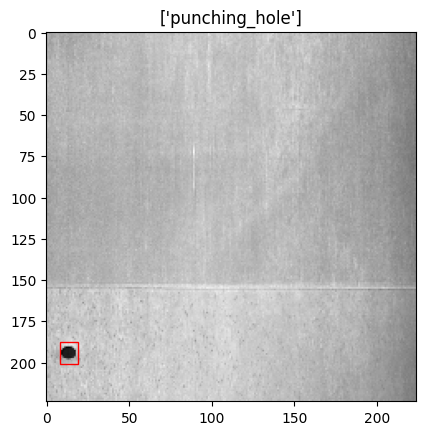

In [ ]:
#def load_image function
def load_image(path):
    image = tf.io.read_file(path)                           
    image = tf.image.decode_jpeg(image,3)               
    image = tf.image.resize(image,[224,224])               
    image = tf.cast(image/127.5-1,tf.float32)                 
    return image      

#build dataset
dataset = tf.data.Dataset.from_tensor_slices(imgs_train)
dataset = dataset.map(load_image)

dataset_label = tf.data.Dataset.zip((dataset,label_datasets))

#batch constant
BATCH_SIZE = 16
AUTO = tf.data.experimental.AUTOTUNE

#batch extraction and shuffle
dataset_label = dataset_label.repeat().shuffle(500).batch(BATCH_SIZE)
dataset_label = dataset_label.prefetch(AUTO)

#Split dataset
test_count = int(len(imgs_train)*0.2)
train_count = len(imgs_train) - test_count
test_count,train_count

train_dataset = dataset_label.skip(test_count)
test_dataset = dataset_label.take(test_count)

species_dict = {v:k for k,v in Class_dict.items()}

#check from train_data
for img, label in train_dataset.take(1):
    plt.imshow(keras.preprocessing.image.array_to_img(img[0]))     
    out1,out2,out3,out4,out5 = label                            
    xmin,ymin,xmax,ymax = out1[0].numpy()*224,out2[0].numpy()*224,out3[0].numpy()*224,out4[0].numpy()*224
    rect = Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,color='r')  
    ax = plt.gca()                      
    ax.axes.add_patch(rect)   
    pred_imglist = []
    pred_imglist.append(species_dict[np.argmax(out5[0])+1])
    plt.title(pred_imglist)
    plt.show()

### 2. Model Building

#### 2.1 The VGG16 model 

In [31]:
#Convolution based
conv = keras.applications.xception.Xception(weights='imagenet',
                                            include_top=False,
                                            input_shape=(224,224,3),
                                            pooling='avg')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
#open trainable
conv.trainable = True

#define Conv + FC structure
inputs = keras.Input(shape=(224,224,3))
x = conv(inputs)
x1 = keras.layers.Dense(1024,activation='relu')(x)
x1 = keras.layers.Dense(512,activation='relu')(x1)


out1 = keras.layers.Dense(1,name='out1')(x1)
out2 = keras.layers.Dense(1,name='out2')(x1)
out3 = keras.layers.Dense(1,name='out3')(x1)
out4 = keras.layers.Dense(1,name='out4')(x1)

x2 = keras.layers.Dense(1024,activation='relu')(x)
x2 = keras.layers.Dropout(0.5)(x2)
x2 = keras.layers.Dense(512,activation='relu')(x2)
out_class = keras.layers.Dense(10,activation='softmax',name='out_item')(x2)

out = [out1,out2,out3,out4,out_class]

model = keras.models.Model(inputs=inputs,outputs=out)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xception            │ (None, 2048)      │ 20,861,480 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1024)      │  2,098,176 │ xception[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  2,098,176 │ xception[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    524,800 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out1 (Dense)        │ (None, 1)         │        513 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out2 (Dense)        │ (None, 1)         │        513 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out3 (Dense)        │ (None, 1)         │        513 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out4 (Dense)        │ (None, 1)         │        513 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out_item (Dense)    │ (None, 10)        │      5,130 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,114,614 (99.62 MB)

 Trainable params: 26,060,086 (99.41 MB)

 Non-trainable params: 54,528 (213.00 KB)

#### 2.2 Compile & Fitting

In [34]:
#model compille
model.compile(keras.optimizers.Adam(0.0003),
             loss={'out1':'mse',
                   'out2':'mse',
                   'out3':'mse',
                   'out4':'mse',
                   'out_item':'categorical_crossentropy'},
             metrics={'out1':['mae'],
                      'out2':['mae'],
                      'out3':['mae'],
                      'out4':['mae'],
                      'out_item':['acc']})


In [35]:
#learning_rate reduce module
lr_reduce = keras.callbacks.ReduceLROnPlateau('val_loss', patience=6, factor=0.5, min_lr=1e-6)

In [36]:
history = model.fit(train_dataset,
                   steps_per_epoch=train_count//BATCH_SIZE,
                   epochs=200,
                   validation_data=test_dataset,
                   validation_steps=test_count//BATCH_SIZE)

Epoch 1/200


I0000 00:00:1760631115.242747      94 service.cc:148] XLA service 0x7ade10002e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760631115.243750      94 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760631118.868098      94 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1760631126.098645      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760631126.294378      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760631127.003219      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760631127.1880

  1/114 ━━━━━━━━━━━━━━━━━━━━ 2:53:35 92s/step - loss: 4.3295 - out1_loss: 0.1807 - out1_mae: 0.3268 - out2_loss: 0.5086 - out2_mae: 0.5862 - out3_loss: 0.7017 - out3_mae: 0.7460 - out4_loss: 0.4798 - out4_mae: 0.5792 - out_item_acc: 0.0000e+00 - out_item_loss: 2.4587

I0000 00:00:1760631137.043790      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


114/114 ━━━━━━━━━━━━━━━━━━━━ 118s 226ms/step - loss: 2.1679 - out1_loss: 0.0930 - out1_mae: 0.2363 - out2_loss: 0.0916 - out2_mae: 0.2230 - out3_loss: 0.1589 - out3_mae: 0.3068 - out4_loss: 0.1315 - out4_mae: 0.2834 - out_item_acc: 0.3984 - out_item_loss: 1.6929 - val_loss: 1.0088 - val_out1_loss: 0.0632 - val_out1_mae: 0.1996 - val_out2_loss: 0.0489 - val_out2_mae: 0.1719 - val_out3_loss: 0.0859 - val_out3_mae: 0.2250 - val_out4_loss: 0.0813 - val_out4_mae: 0.2155 - val_out_item_acc: 0.7679 - val_out_item_loss: 0.7295
Epoch 2/200
114/114 ━━━━━━━━━━━━━━━━━━━━ 22s 190ms/step - loss: 0.8937 - out1_loss: 0.0459 - out1_mae: 0.1608 - out2_loss: 0.0363 - out2_mae: 0.1433 - out3_loss: 0.0545 - out3_mae: 0.1826 - out4_loss: 0.0575 - out4_mae: 0.1913 - out_item_acc: 0.7630 - out_item_loss: 0.6996 - val_loss: 1.1185 - val_out1_loss: 0.0748 - val_out1_mae: 0.2278 - val_out2_loss: 0.0364 - val_out2_mae: 0.1563 - val_out3_loss: 0.0377 - val_out3_mae: 0.1479 - val_out4_loss: 0.0552 - val_out4_mae: 0

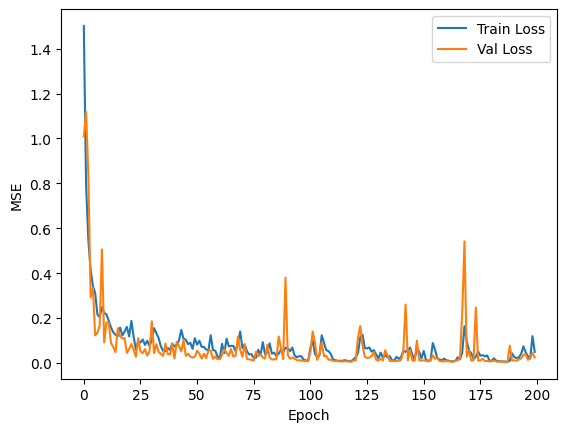

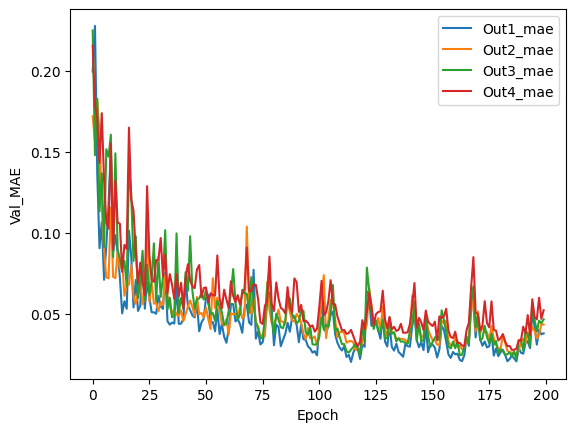

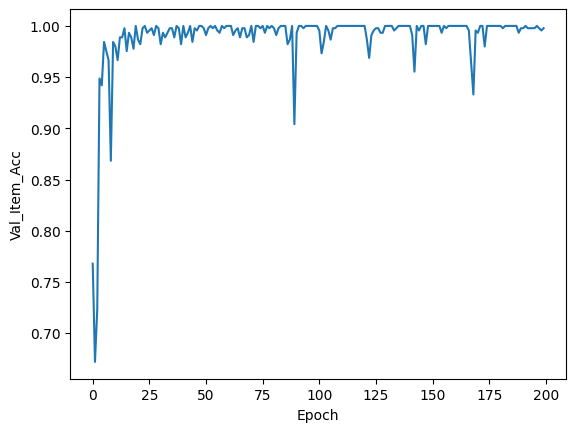

In [37]:
#training visualization
def plot_history(history):                
    hist = pd.DataFrame(history.history)           
    hist['epoch']=history.epoch
    
    plt.figure()                                     
    plt.xlabel('Epoch')
    plt.ylabel('MSE')               
    plt.plot(hist['epoch'],hist['loss'],
            label='Train Loss')
    plt.plot(hist['epoch'],hist['val_loss'],
            label='Val Loss')                           
    plt.legend()
    
    plt.figure()                                      
    plt.xlabel('Epoch')
    plt.ylabel('Val_MAE')               
    plt.plot(hist['epoch'],hist['val_out1_mae'],
            label='Out1_mae')
    plt.plot(hist['epoch'],hist['val_out2_mae'],
            label='Out2_mae')
    plt.plot(hist['epoch'],hist['val_out3_mae'],
            label='Out3_mae')
    plt.plot(hist['epoch'],hist['val_out4_mae'],
            label='Out4_mae')
    plt.legend()      
    
    plt.figure()                                      
    plt.xlabel('Epoch')
    plt.ylabel('Val_Item_Acc')               
    plt.plot(hist['epoch'],hist['val_out_item_acc'],
            label='Out5_acc')
    
    plt.show()
    
plot_history(history)      

#### 2.3 Model Evaluation

In [38]:
mae = model.evaluate(test_dataset)

456/456 ━━━━━━━━━━━━━━━━━━━━ 34s 69ms/step - loss: 0.0418 - out1_loss: 0.0037 - out1_mae: 0.0406 - out2_loss: 0.0053 - out2_mae: 0.0460 - out3_loss: 0.0042 - out3_mae: 0.0448 - out4_loss: 0.0071 - out4_mae: 0.0546 - out_item_acc: 0.9956 - out_item_loss: 0.0214


In [39]:
print('out1_mae in test:{}'.format(mae[6]))
print('out2_mae in test:{}'.format(mae[8]))
print('out3_mae in test:{}'.format(mae[10]))
# print('out4_mae in test:{}'.format(mae[12]))
# print('class_label in test:{}'.format(mae[15]))

out1_mae in test:0.04126393422484398
out2_mae in test:0.04453423246741295
out3_mae in test:0.9953399300575256


In [40]:
model.save("class_location.h5")

In [46]:
import shutil

# Save and zip model
model.save("/kaggle/working/class_location.h5")
shutil.make_archive("/kaggle/working/class_location", 'zip', "/kaggle/working", "class_location.h5")

'/kaggle/working/class_location.zip'

In [41]:
species_dict = {v:k for k,v in Class_dict.items()}

In [42]:
species_dict

{1: 'crescent_gap',
 2: 'crease',
 3: 'silk_spot',
 4: 'water_spot',
 5: 'welding_line',
 6: 'inclusion',
 7: 'oil_spot',
 8: 'waist folding',
 9: 'rolled_pit',
 10: 'punching_hole'}

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


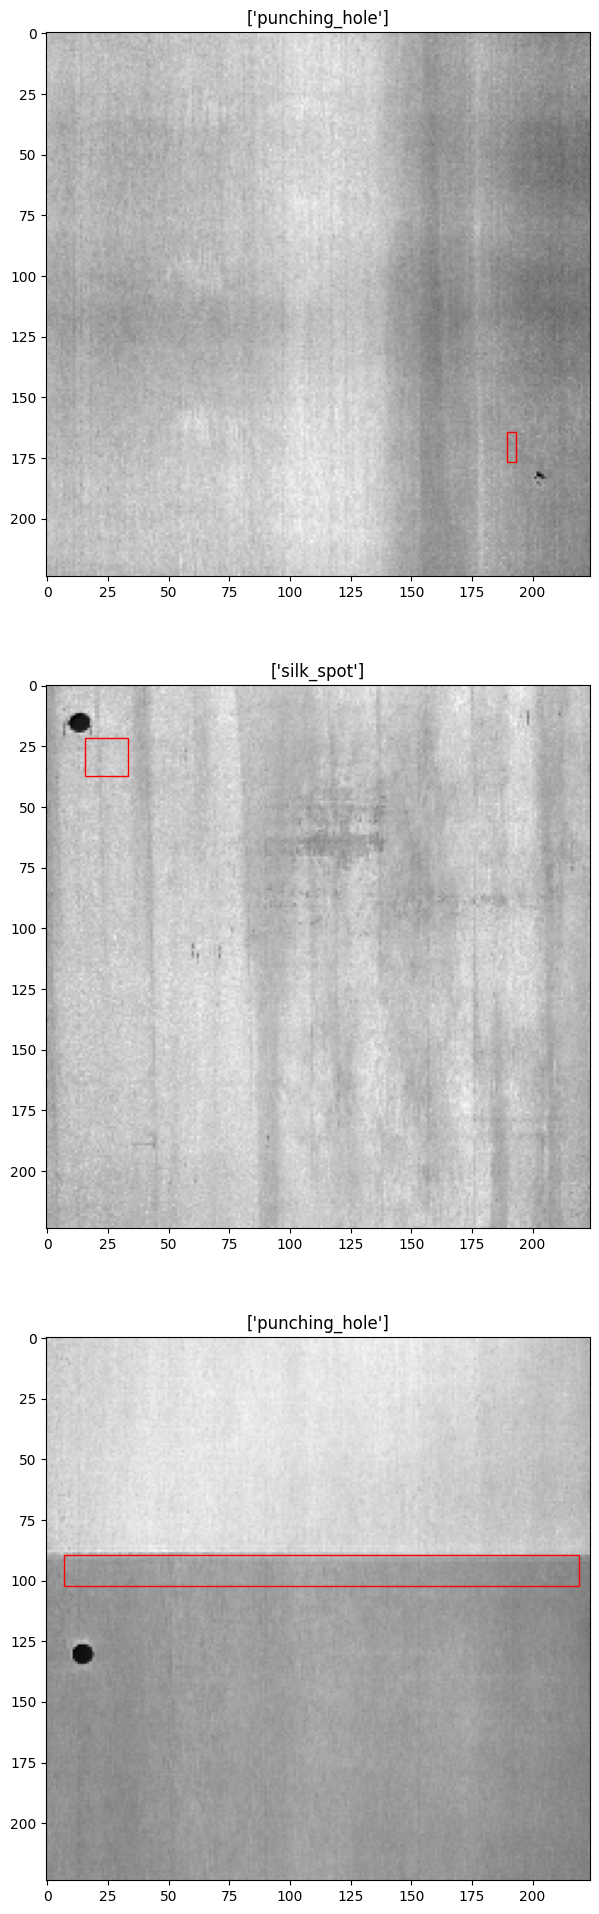

In [43]:
plt.figure(figsize=(10,24))
for img,_ in train_dataset.take(1):
    out1,out2,out3,out4,label = model.predict(img)
    for i in range(3):
        plt.subplot(3,1,i+1)            
        plt.imshow(keras.preprocessing.image.array_to_img(img[i]))    
        pred_imglist = []
        pred_imglist.append(species_dict[np.argmax(out5[i])+1])
        plt.title(pred_imglist)
        xmin,ymin,xmax,ymax = out1[i]*224,out2[i]*224,out3[i]*224,out4[i]*224
        rect = Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,color='r') 
        ax = plt.gca()                   
        ax.axes.add_patch(rect)        

# Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class: class6
Confidence: 0.9998
Bounding Box (xmin, ymin, xmax, ymax): (206.45897102355957, 164.0760383605957, 207.52852821350098, 173.9470920562744)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


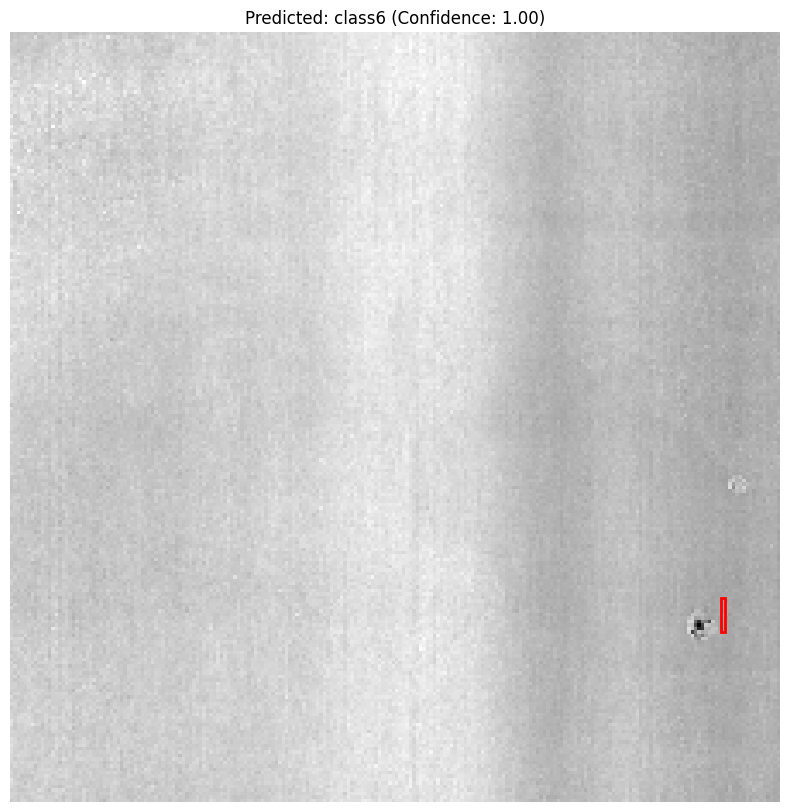

{'bbox': (206.45897102355957,
  164.0760383605957,
  207.52852821350098,
  173.9470920562744),
 'class': 'class6',
 'confidence': 0.9998461008071899,
 'image': <tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[-0.3362645 , -0.3362645 , -0.3362645 ],
         [-0.32053816, -0.32053816, -0.32053816],
         [-0.33763504, -0.33763504, -0.33763504],
         ...,
         [-0.38814437, -0.38814437, -0.38814437],
         [-0.38904488, -0.38904488, -0.38904488],
         [-0.37269878, -0.37269878, -0.37269878]],
 
        [[-0.3316226 , -0.3316226 , -0.3316226 ],
         [-0.31816727, -0.31816727, -0.31816727],
         [-0.32719094, -0.32719094, -0.32719094],
         ...,
         [-0.40238094, -0.40238094, -0.40238094],
         [-0.3870247 , -0.3870247 , -0.3870247 ],
         [-0.39485037, -0.39485037, -0.39485037]],
 
        [[-0.327451  , -0.327451  , -0.327451  ],
         [-0.29245698, -0.29245698, -0.29245698],
         [-0.31232494, -0.31232494, -0.31232494],
 

In [44]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

# Load the saved model without compilation
model = keras.models.load_model("class_location.h5", compile=False)

# Define the class dictionary (update this with your actual classes)
species_dict = {
    1: 'class1',
    2: 'class2',
    3: 'class3',
    4: 'class4',
    5: 'class5',
    6: 'class6',
    7: 'class7',
    8: 'class8',
    9: 'class9',
    10: 'class10'
}

# Load and preprocess single image
def load_and_preprocess_image(image_path):
    """Load and preprocess a single image for inference"""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, 3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image / 127.5 - 1, tf.float32)
    return image

# Inference function
def predict_single_image(image_path):
    """Run inference on a single image"""
    # Load and preprocess image
    img = load_and_preprocess_image(image_path)
    img_batch = tf.expand_dims(img, 0)  # Add batch dimension
    
    # Make prediction
    out1, out2, out3, out4, out_class = model.predict(img_batch)
    
    # Extract predictions
    xmin = float(out1[0][0]) * 224
    ymin = float(out2[0][0]) * 224
    xmax = float(out3[0][0]) * 224
    ymax = float(out4[0][0]) * 224
    
    # Get predicted class
    predicted_class_idx = np.argmax(out_class[0]) + 1
    predicted_class = species_dict[predicted_class_idx]
    confidence = float(out_class[0][predicted_class_idx - 1])
    
    return {
        'bbox': (xmin, ymin, xmax, ymax),
        'class': predicted_class,
        'confidence': confidence,
        'image': img
    }

# Visualize prediction
def visualize_prediction(image_path):
    """Visualize the prediction with bounding box"""
    result = predict_single_image(image_path)
    
    # Create plot
    plt.figure(figsize=(10, 10))
    plt.imshow(keras.preprocessing.image.array_to_img(result['image']))
    
    # Draw bounding box
    xmin, ymin, xmax, ymax = result['bbox']
    rect = Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), 
                     fill=False, color='r', linewidth=2)
    ax = plt.gca()
    ax.add_patch(rect)
    
    # Add title with class and confidence
    plt.title(f"Predicted: {result['class']} (Confidence: {result['confidence']:.2f})")
    plt.axis('off')
    plt.show()
    
    return result

# Example usage
image_path = '/kaggle/input/defects-class-and-location/images/images/inclusion/img_02_425392000_00984.jpg'
result = predict_single_image(image_path)

# Print results
print(f"Predicted Class: {result['class']}")
print(f"Confidence: {result['confidence']:.4f}")
print(f"Bounding Box (xmin, ymin, xmax, ymax): {result['bbox']}")

# Visualize
visualize_prediction(image_path)


In [53]:
from IPython.display import FileLink
FileLink("class_location.h5")

/kaggle/working/class_location.h5